<a href="https://colab.research.google.com/github/alyahoang99/causal_inference_synthetic_data/blob/main/ops_experiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.formula.api as smf

In [2]:
from matplotlib import pyplot
def show_metric_by_treatment(df, metric, hist_range, hist_bins, metric_name):
    pyplot.hist(
        df[df.treatment == 1][metric].values,
        label = 'treatment',
        alpha = 0.5, range = hist_range, bins = hist_bins,
        color = 'navy',
        weights = np.ones_like(df[df.treatment == 1].index)*100/df[df.treatment == 1].shape[0]
    )

    pyplot.hist(
        df[df.treatment == 0][metric].values,
        label = 'control',
        alpha = 0.5, range = hist_range, bins = hist_bins,
        color = 'red',
        weights = np.ones_like(df[df.treatment == 0].index)*100/df[df.treatment == 0].shape[0]
    )

    pyplot.legend(loc = 'upper right')
    pyplot.title('Distribution of %s' % metric_name)
    pyplot.xlabel('')
    pyplot.ylabel('share of users, %')
    pyplot.show()

In [3]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/causal_inference_linear_regression/ops_experiment_synthetic_v2.csv')

In [5]:
df.head()

case_id  agent_id  treatment  time_spent_mins cs-center complexity  tenure  \
0        0         0          0            14.54  FutureCS        low       6   
1        1         0          0            11.89  FutureCS        low       6   
2        2         0          0            11.83  FutureCS        low       6   
3        3         0          0            15.44  FutureCS        low       6   
4        4         0          0            13.47  FutureCS        low       6   

   passed_training  within_sla  
0                0           1  
1                0           1  
2                0           1  
3                0           0  
4                0           1

In [13]:
model = smf.ols('time_spent_mins ~ treatment + complexity', data=df).fit()
model.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

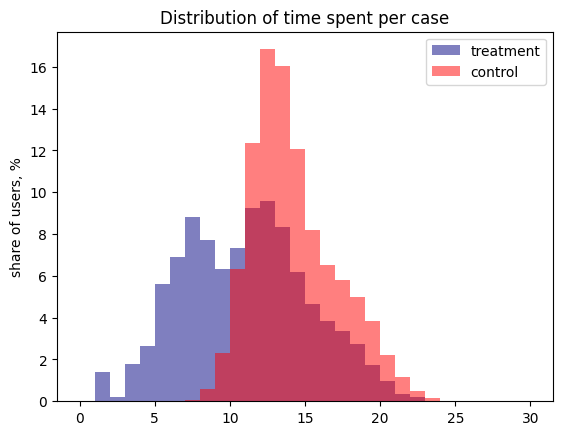

In [6]:
import numpy as np
show_metric_by_treatment(df, 'time_spent_mins', [0, 30], 30,
                        'time spent per case')

show a summary table with count of cases, unique agents and average time spent on cases for each treatment group (0 and 1). this table provides insights into how the treatment affects these metrics

In [7]:
df.groupby('treatment').aggregate(
    {'case_id': 'count', 'agent_id': 'nunique', 'time_spent_mins': 'mean'}
)

case_id  agent_id  time_spent_mins
treatment                                    
0            43758       443            14.27
1            48063       479            11.05

In [8]:
df.groupby('treatment').time_spent_mins.var()

treatment
0    8.11
1   17.72
Name: time_spent_mins, dtype: float64

In [9]:
# aggregateing statistics by complexity
comp_stats_df = df.groupby('complexity', as_index = False).aggregate({'case_id':'nunique', 'time_spent_mins': ['mean', 'std']})
comp_stats_df.columns = ['complexity', 'cases', 'avg_time_spent_mins', 'std_time_spent_mins']
comp_stats_df['share'] = comp_stats_df.cases*100/comp_stats_df.cases.sum()
comp_stats_df.sort_values('cases', ascending = False)[['complexity', 'cases', 'share', 'avg_time_spent_mins', 'std_time_spent_mins']]


complexity  cases  share  avg_time_spent_mins  std_time_spent_mins
1        low  55809  60.78                11.05                 3.25
2     medium  28252  30.77                16.05                 3.20
0       high   7760   8.45                11.03                 3.14

In [10]:
import plotly.io as pio
pio.templates.default = 'simple_white'
import plotly.express as px

In [11]:
fig = px.violin(df, x='complexity', y='time_spent_mins', height=600, category_orders = {'complexity': ['low', 'medium', 'high']},
                title='<b>Distribution of average time spent by complexity</b>',
                labels = {'time_spent_mins': 'time spent in minutes'})
fig.show()

after adding complexity, we got a more confident result since time spent on a customer case significantly depends on the complexity of the tasks. So, complexity is responsible for a significant amount of our variable's variability
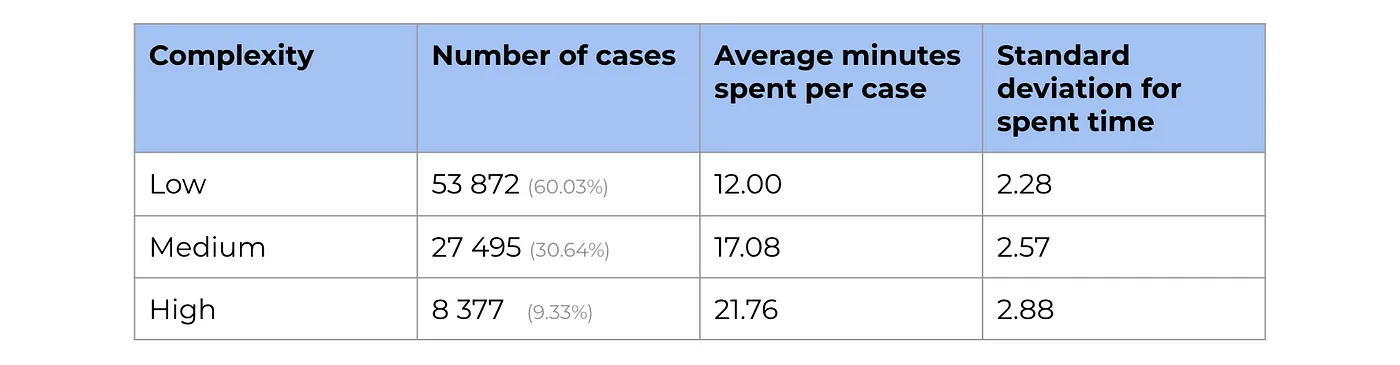

In [12]:
control_values = df[df.treatment == 0].time_spent_mins.values
exp_values = df[df.treatment == 1].time_spent_mins.values

In [14]:
from scipy.stats import ttest_ind
ttest_ind(exp_values, control_values)

TtestResult(statistic=-134.53516824906652, pvalue=0.0, df=91819.0)

In [16]:
from scipy import stats
import numpy as np

# calculate sample statistics
mean1, mean2 = np.mean(exp_values), np.mean(control_values)
std1, std2 = np.std(exp_values, ddof=1), np.std(control_values, ddof=1)
n1, n2 = len(exp_values), len(control_values)

# calculate pooled standard deviation
pooled_std = np.sqrt(((n1-1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 -2))
# calculate degrees of freedom
degrees_of_freedom = n1 + n2 -2

# set confidence level
confidence_level = 0.95

# calculate margin of error
margin_of_error = stats.t.ppf((1 + confidence_level)/2, degrees_of_freedom) * pooled_std * np.sqrt(1/ n1 + 1/ n2)

# calculate confidence interval
mean_difference = mean1 - mean2
conf_interval = (mean_difference - margin_of_error, mean_difference + margin_of_error)

print('Confidence Interval:', list(map(lambda x: round(x, 3), conf_interval)))

Confidence Interval: [-3.269, -3.175]


In [17]:
model = smf.ols('time_spent_mins ~ treatment', data=df).fit()
model.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [18]:
time_model = smf.ols('time_spent_mins ~ complexity', data=df).fit()
print('Initial variance: %.2f, Residual variance after accounting for complexity: %.2f' % (df.time_spent_mins.var(), time_model.resid.var(),))

Initial variance: 15.73, Residual variance after accounting for complexity: 10.41


we should expect different impacts from treatment for these two groups, we can use non-linearity to express such relationships in formulas and add treatment * passed_training component to our equation.

In [19]:
model = smf.ols('time_spent_mins ~ treatment + complexity', data=df).fit()
model.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

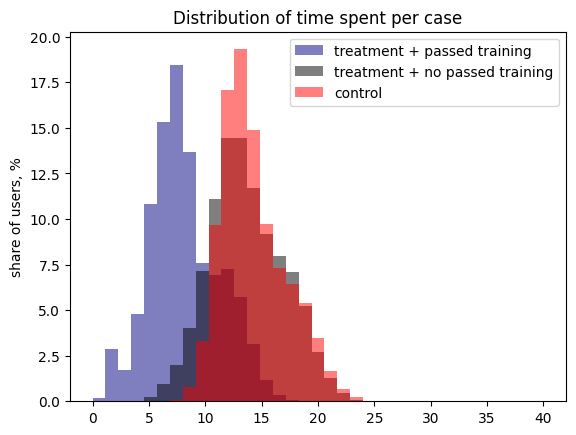

In [23]:
metric = 'time_spent_mins'
metric_name = 'time spent per case'
hist_range = [0, 40]
hist_bins = 35

pyplot.hist(
    df[(df.treatment == 1) & (df.passed_training == 1)][metric].values,
    label = 'treatment + passed training',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'navy',
    weights = np.ones_like(df[(df.treatment == 1) & (df.passed_training == 1)].index)*100/df[(df.treatment == 1) & (df.passed_training == 1)].shape[0]
)

pyplot.hist(
    df[(df.treatment == 1) & (df.passed_training == 0)][metric].values,
    label = 'treatment + no passed training',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'black',
    weights = np.ones_like(df[(df.treatment == 1) & (df.passed_training == 0)].index)*100/df[(df.treatment == 1) & (df.passed_training == 0)].shape[0]
)

pyplot.hist(
    df[df.treatment == 0][metric].values,
    label = 'control',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'red',
    weights = np.ones_like(df[df.treatment == 0].index)*100/df[df.treatment == 0].shape[0]

)

pyplot.legend(loc = 'upper right')
pyplot.title('Distribution of %s' % metric_name)
pyplot.xlabel('')
pyplot.ylabel('share of users, %')
pyplot.show()

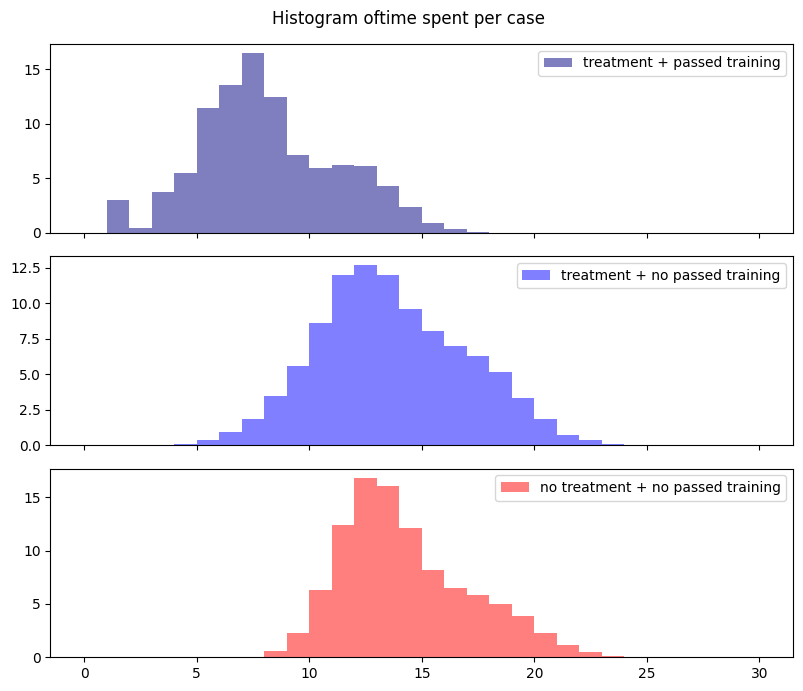

In [26]:
metric = 'time_spent_mins'
metric_name = 'time spent per case'
hist_range = [0, 30]
hist_bins = 30


fig, axs = pyplot.subplots(3, 1, sharex = True, tight_layout=True, figsize=(8, 7))

axs[0].hist(
    df[(df.treatment == 1) & (df.passed_training == 1)][metric].values,
    label = 'treatment + passed training',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'navy',
    weights = np.ones_like(df[(df.treatment == 1) & (df.passed_training == 1)].index)*100/df[(df.treatment == 1) & (df.passed_training == 1)].shape[0]
)

axs[1].hist(
    df[(df.treatment == 1) & (df.passed_training == 0)][metric].values,
    label = 'treatment + no passed training',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'blue',
    weights = np.ones_like(df[(df.treatment == 1) & (df.passed_training == 0)].index)*100/df[(df.treatment == 1) & (df.passed_training == 0)].shape[0]
)

axs[2].hist(
    df[(df.treatment == 0) & (df.passed_training == 0)][metric].values,
    label = 'no treatment + no passed training',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'red',
    weights = np.ones_like(df[(df.treatment == 0) & (df.passed_training == 0)].index)*100/df[(df.treatment == 0) & (df.passed_training == 0)].shape[0]
)

# adding legend
for ax in axs:
  ax.legend()

# adding title
fig.suptitle('Histogram of' + metric_name)

pyplot.show()

In [27]:
stats_df = df.groupby(['treatment', 'passed_training'], as_index = False).aggregate({
    'case_id': 'count', 'time_spent_mins': 'mean'
})
stats_df['share'] = stats_df.case_id*100/stats_df.case_id.sum()
stats_df

treatment  passed_training  case_id  time_spent_mins  share
0          0                0    43758            14.27  47.66
1          1                0    25244            13.68  27.49
2          1                1    22819             8.15  24.85

In [28]:
model = smf.ols('time_spent_mins ~ treatment * passed_training + complexity', data=df).fit()
model.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [32]:
def get_tenure_bucket(tenure):
    if tenure <= 3:
        return '0 - 3 months'
    if tenure <= 6:
        return '4 - 6 months'
    if tenure <= 12:
        return '7 - 12 months'
    if tenure <= 24:
        return '1 - 2 years'
    if tenure <= 36:
        return '2 - 3 years'
    return '3+ years'


df['tenure_bucket'] = df.tenure.map(get_tenure_bucket)

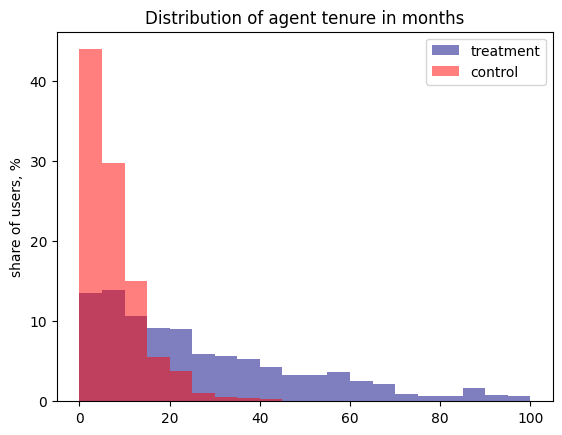

In [33]:
show_metric_by_treatment(df, 'tenure', [0,100], 20, 'agent tenure in months')

In [34]:
px.box(df, x='tenure_bucket', y='time_spent_mins', title='<b>Time spent per case</b> depending on agents experience',
       labels = {'time_spent_mins': 'time spent in minutes', 'tenure_bucket': 'tenure'}, height = 500,
       category_orders = {'tenure_bucket': ['0 - 3 months', '4-6 months', '7-12 months', '1-2 years', '2-3 years', '3+ years']})

In [35]:
model = smf.ols('time_spent_mins ~ treatment * passed_training + complexity + tenure', data = df).fit()
model.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [36]:
df.head()

case_id  agent_id  treatment  time_spent_mins cs-center complexity  tenure  \
0        0         0          0            14.54  FutureCS        low       6   
1        1         0          0            11.89  FutureCS        low       6   
2        2         0          0            11.83  FutureCS        low       6   
3        3         0          0            15.44  FutureCS        low       6   
4        4         0          0            13.47  FutureCS        low       6   

   passed_training  within_sla tenure_bucket  
0                0           1  4 - 6 months  
1                0           1  4 - 6 months  
2                0           1  4 - 6 months  
3                0           0  4 - 6 months  
4                0           1  4 - 6 months

In [37]:
model = smf.ols('time_spent_mins ~ treatment + complexity + tenure', data=df[df.treatment == df.passed_training]).fit()
model.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [38]:
model = smf.ols('time_spent_mins ~ treatment + complexity + tenure + within_sla', data=df[df.treatment == df.passed_training]).fit()
model.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [39]:
agent_df = df.groupby(['agent_id', 'treatment', 'complexity', 'tenure', 'passed_training'], as_index = False).aggregate(
    {'case_id': 'nunique', 'time_spent_mins': 'mean'}
)

In [43]:
model = smf.ols('time_spent_mins ~ treatment + complexity + tenure', data=agent_df[agent_df.treatment == agent_df.passed_training],
               weights = agent_df[agent_df.treatment == agent_df.passed_training]['case_id']).fit()
model.summary().tables[1]

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:923: ValueWarning:

Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:130: ValueWarning:

unknown kwargs ['weights']



<class 'statsmodels.iolib.table.SimpleTable'>

In [45]:
agent_df.groupby(['passed_training', 'treatment'], as_index = False).time_spent_mins.mean()

passed_training  treatment  time_spent_mins
0                0          0            14.24
1                0          1            13.65
2                1          1             8.16